In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import random

In [2]:
#N(v) l'insieme degli adiacenti di v in G
def get_edges(nodo, nxG):
    nodi=nxG.edges(nodo)
    lista_nodi=list(nodi)
    lista=[]
    for i in range(0,len(lista_nodi)):
        lista.append(lista_nodi[i][1])
    return lista

#d(v) il grado di v in G, cioè d(v) = |N(v)|
def grado_nodo(nodo, nxG):
    nodi=nxG.edges(nodo)
    lista_nodi=list(nodi)
    return len(lista_nodi)

#Un dominating set D di G è un sottoinsieme dei vertici di G tale che
# per ogni v ∈ V - D vale che |N(v) intersecato D| >= 1
def check_dominating_set(lista_nodi, nxG):
    lista_v=nxG.nodes
    lista_v_meno_d=[item for item in lista_v if item not in lista_nodi]
    for v in lista_v_meno_d:
        if not check_edge(v,nxG,lista_nodi):
            return False
    return True

#Check se un nodo v ha uno degli edges di lista
def check_edge(v, nxG, lista):
    list1=get_edges(v,nxG)
    found=any(item in list1 for item in lista)
    return found

#Un majority dominating set D di G è un sottinsieme dei vertici di G tale che
# per ogni v ∈ V - D vale che |N(v) intersecato D| >= [d(v)/2]
def check_majority_dominating_set(lista_nodi, nxG):
    lista_v=nxG.nodes
    lista_v_meno_d=[item for item in lista_v if item not in lista_nodi]
    for v in lista_v_meno_d:
        if not num_check_edges(v, nxG, lista_nodi) >= math.ceil(grado_nodo(v,nxG)/2):
            return False
    return True

#Check numero di elementi connessi
def num_check_edges(v, nxG, lista):
    list1=get_edges(v,nxG)
    connected_elements = [item for item in lista if item in list1]
    return len(connected_elements)


In [3]:
#Majority dynamical process di Influence Diffusion
def influence_diffusion(nxG, seed_set):
    inf_curr = set(seed_set)
    inf_prev = set()
    step = 0

    while inf_prev != inf_curr:
        inf_prev = inf_curr.copy()
        new_activated = set()
        for v in nxG.nodes:
            if v not in inf_prev:
                neighbors = get_edges(v, nxG)
                activated_neighbors = [n for n in neighbors if n in inf_prev]
                if len(activated_neighbors) >= math.ceil(grado_nodo(v,nxG)/2):
                    new_activated.add(v)
        inf_curr.update(new_activated)
        print(inf_curr)
        step += 1

    return inf_curr, step-1

In [4]:
import networkx as nx
from collections import defaultdict

def wtss(G, thresholds, costs, max_cost):
    # Step 1: Initialization
    S = set()  # Target set
    U = set(G.nodes())  # Set of all vertices
    current_cost = 0  # Current cost of the target set S

    # Step 2: Define initial values for δ, k, and N
    delta = {v: G.degree[v] for v in G.nodes()}
    k = {v: thresholds[v] for v in G.nodes()}
    N = {v: set(G.neighbors(v)) for v in G.nodes()}

    # Step 3: While U is not empty and current cost is within the limit
    while U and current_cost <= max_cost:
        # Step 4: Check if there exists a vertex v in U such that k(v) = 0
        found_case_1 = False
        for v in U:
            if k[v] == 0:
                found_case_1 = True
                break

        if found_case_1:
            # Case 1: The selected vertex v is activated by the influence of its neighbors in V-U only
            for u in N[v]:
                k[u] = max(0, k[u] - 1)
        else:
            found_case_2 = False
            # Step 9: Check if there exists a vertex v in U such that δ(v) < k(v)
            for v in U:
                if delta[v] < k[v]:
                    found_case_2 = True
                    break

            if found_case_2:
                # Case 2: The vertex v is added to S
                if current_cost + costs[v] > max_cost:
                    break  # Stop if adding this vertex would exceed max_cost
                S.add(v)
                current_cost += costs[v]
                for u in N[v]:
                    k[u] = k[u] - 1
            else:
                # Case 3: Select the vertex v to be activated by its neighbors in U
                v = min(U, key=lambda u: costs[u] * k[u] / (delta[u] * (delta[u] + 1)))
                for u in N[v]:
                    delta[u] = delta[u] - 1
                    N[u].remove(v)
        
        # Remove the selected vertex v from the graph
        U.remove(v)

    return S


In [5]:
import networkx as nx
from math import ceil

def f1(S, G):
    result = 0
    for v in G.nodes():
        result += min(len(set(G.neighbors(v)) & S), ceil(G.degree[v] / 2))
    return result

def f2(S, G):
    result = 0
    for v in G.nodes():
        common_neighbors = len(set(G.neighbors(v)) & S)
        for i in range(1, common_neighbors + 1):
            result += max(ceil(G.degree[v] / 2) - i + 1, 0)
    return result


def f3(S, G):
    result = 0
    for v in G.nodes():
        common_neighbors = len(set(G.neighbors(v)) & S)
        for i in range(1, common_neighbors + 1):
            result += max(ceil(G.degree[v] / 2) - i + 1  / (G.degree(v) - i + 1), 0)
    return result

def cost_seeds_greedy(G, k, costs, f):
    Sp = set()
    Sd = set()

    def delta_fi(Sd, u, f, G):
        Sd_with_u = Sd | {u}
        return f(Sd_with_u, G) - f(Sd, G)

    while True:
        best_u = None
        best_ratio = float('-inf')
        
        for u in G.nodes() - Sd:
            ratio = delta_fi(Sd, u, f, G) / costs[u]
            if ratio > best_ratio:
                best_ratio = ratio
                best_u = u
        
        if best_u is None:
            break
        
        Sd.add(best_u)
        if sum(costs[u] for u in Sd) > k:
            break
        
        Sp = Sd.copy()

    return Sp

In [6]:
import networkx as nx

def marginal_gain(G, S, v):
    """
    Calcola il guadagno marginale di aggiungere il nodo v al seed set S.
    In questo esempio, useremo la somma dei gradi dei nodi influenzati come proxy per il guadagno.
    """
    influenced_nodes = set(S)  # Noduli già influenzati dal seed set S
    new_influenced_nodes = set()
    
    for u in S:
        new_influenced_nodes.update(G.neighbors(u))
    
    if v not in influenced_nodes:
        new_influenced_nodes.update(G.neighbors(v))
    
    return len(new_influenced_nodes - influenced_nodes)

def my_seeds(G, k, c):
    """
    Implementazione dell'algoritmo My-Seeds.
    G: Grafo nx.Graph
    k: Budget intero
    c: Dizionario con costi dei nodi {nodo: costo}
    """
    Sa = set()  # Seed set iniziale vuoto
    total_cost = 0
    
    while total_cost < k:
        best_node = None
        best_gain = 0
        best_cost = 1  # Assicurarsi che il rapporto sia significativo
        
        for v in G.nodes():
            if v not in Sa:
                gain = marginal_gain(G, Sa, v)
                cost = c[v]
                if cost > 0:  # Evitare divisioni per zero
                    gain_cost_ratio = gain / cost
                    if gain_cost_ratio > best_gain / best_cost:
                        best_node = v
                        best_gain = gain
                        best_cost = cost
        
        if best_node is None or total_cost + best_cost > k:
            break
        
        Sa.add(best_node)
        total_cost += best_cost
    
    return Sa


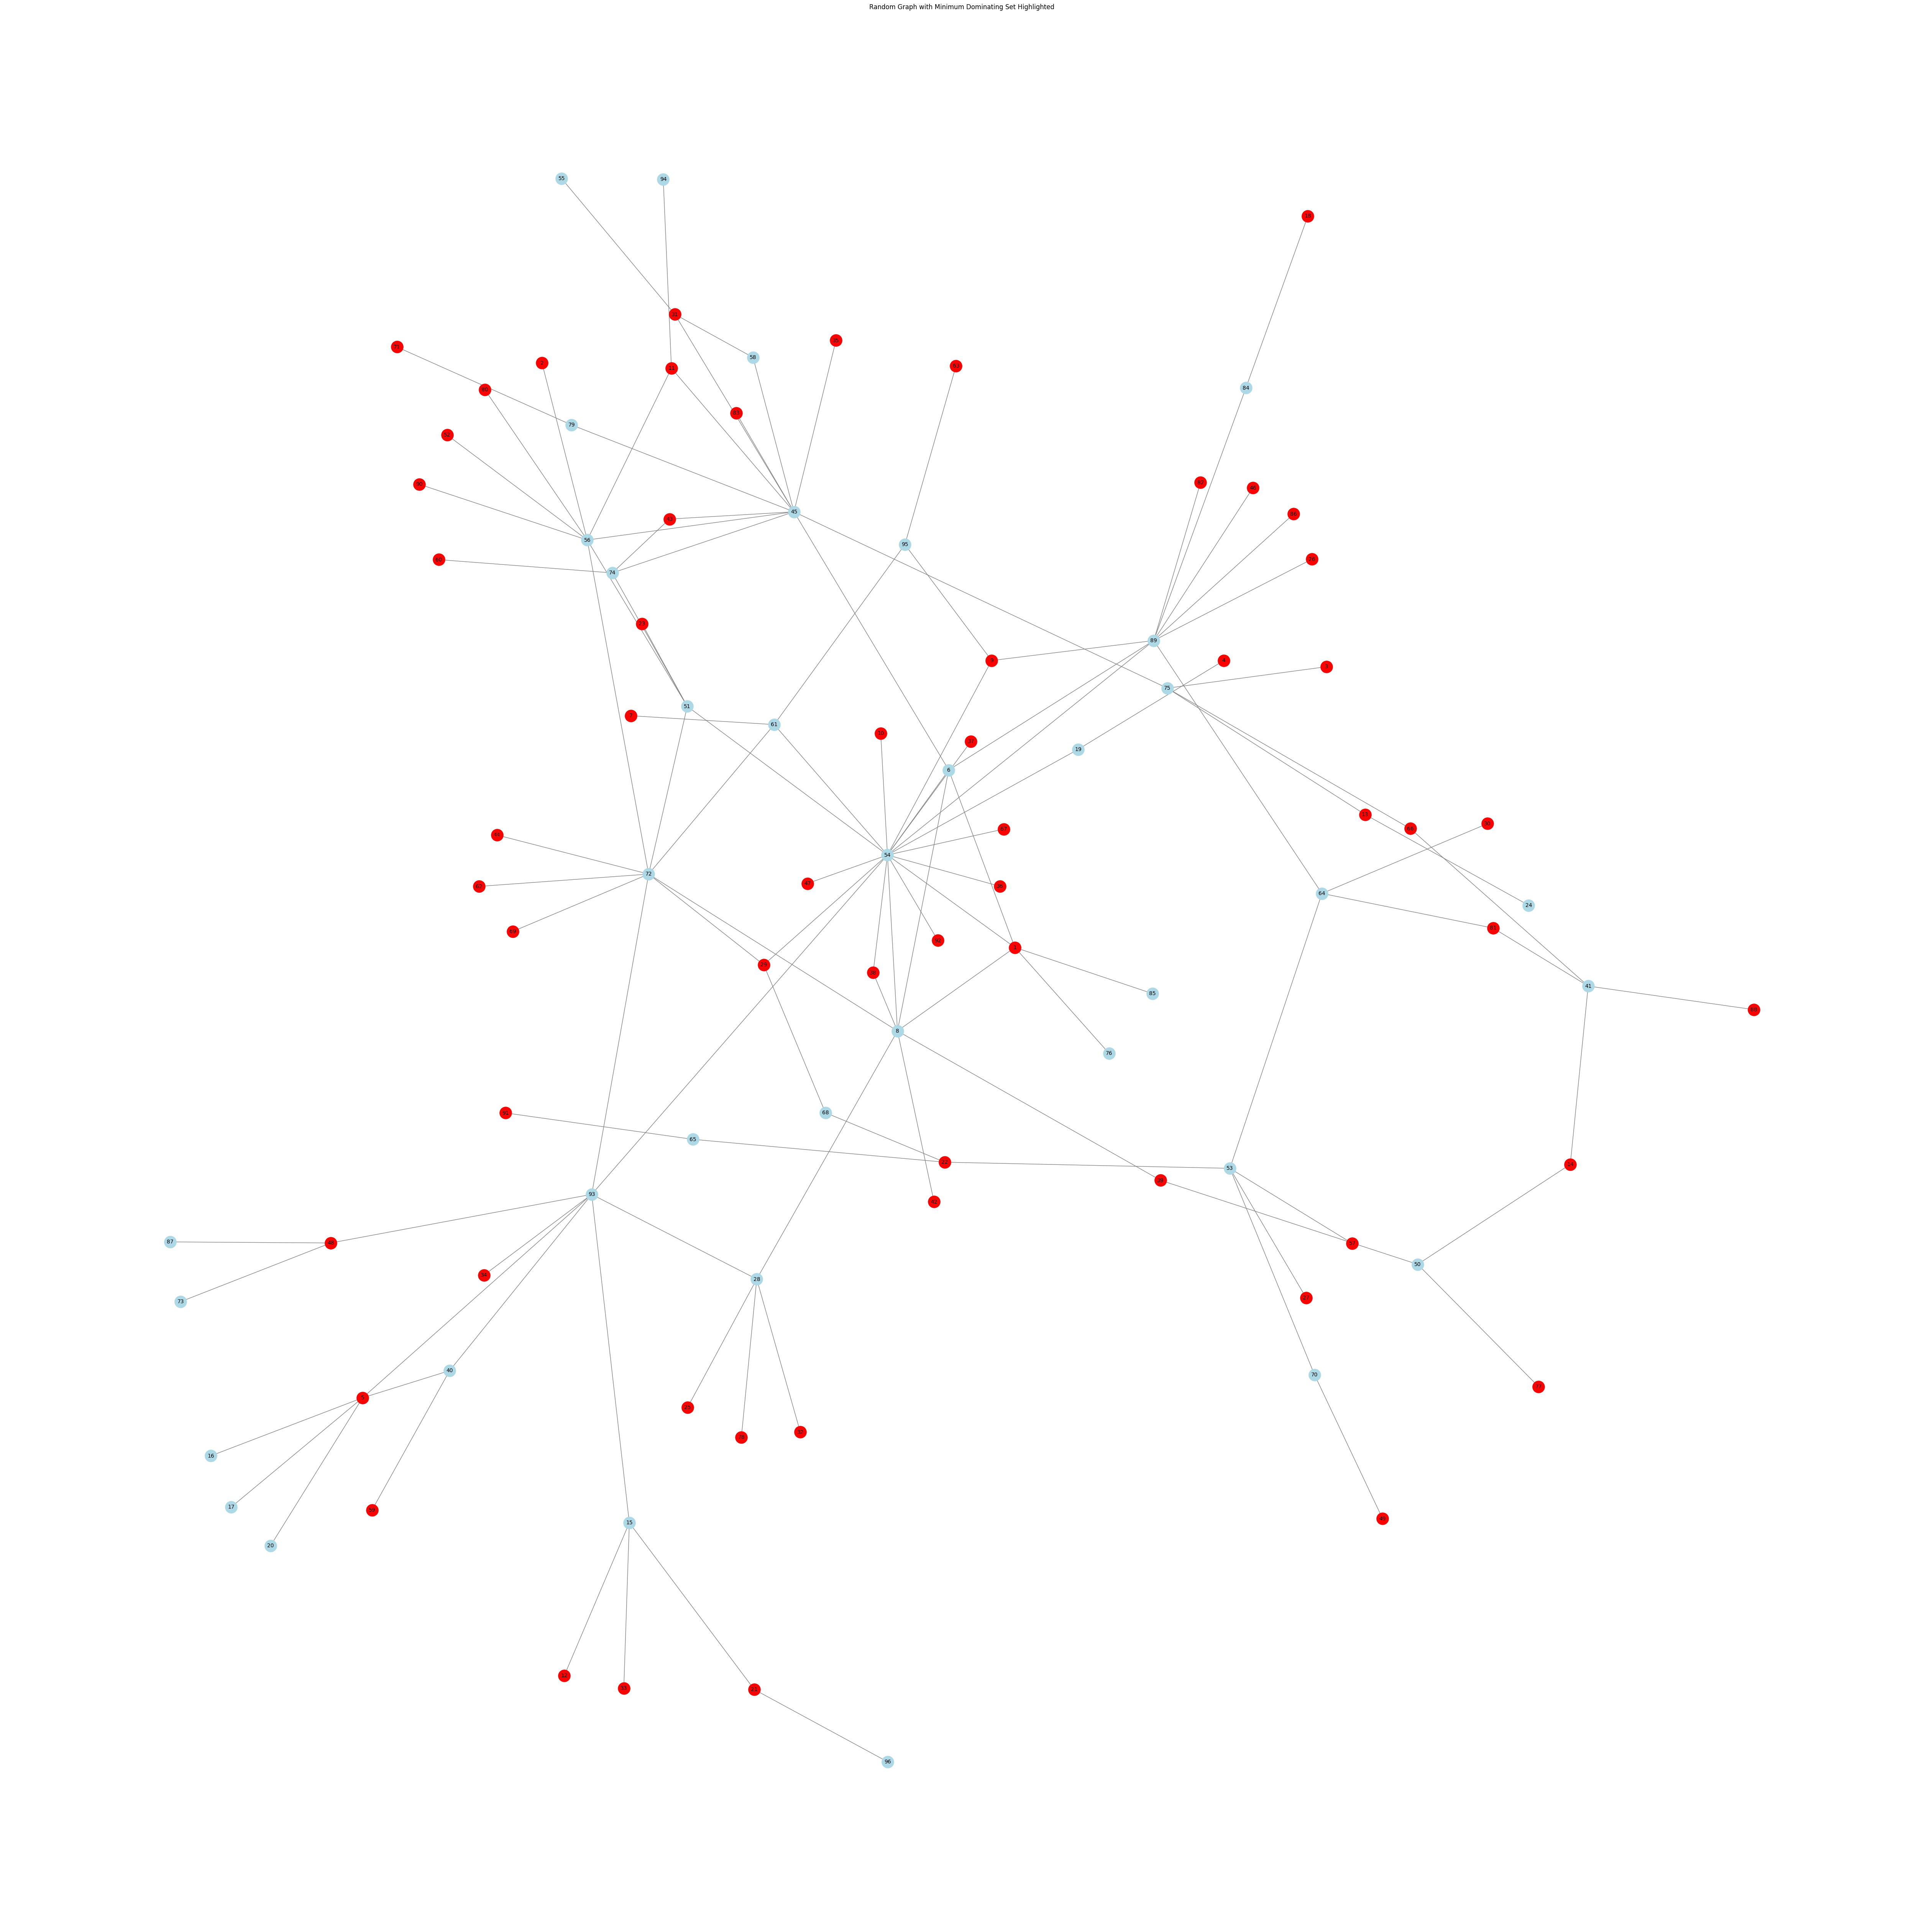

Costi: {0: 1, 1: 2, 2: 2, 3: 9, 4: 9, 5: 5, 6: 8, 7: 5, 8: 5, 9: 2, 10: 6, 11: 3, 12: 5, 13: 10, 14: 5, 15: 4, 16: 9, 17: 7, 18: 7, 19: 10, 20: 10, 21: 3, 22: 1, 23: 9, 24: 3, 25: 9, 26: 3, 27: 4, 28: 10, 29: 4, 30: 10, 31: 7, 32: 10, 33: 9, 34: 3, 35: 5, 36: 5, 37: 5, 38: 9, 39: 1, 40: 10, 41: 1, 42: 1, 43: 6, 44: 6, 45: 10, 46: 7, 47: 9, 48: 8, 49: 4, 50: 7, 51: 10, 52: 10, 53: 6, 54: 6, 55: 9, 56: 9, 57: 10, 58: 5, 59: 5, 60: 8, 61: 1, 62: 4, 63: 10, 64: 4, 65: 4, 66: 1, 67: 2, 68: 6, 69: 3, 70: 5, 71: 2, 72: 3, 73: 1, 74: 10, 75: 3, 76: 2, 77: 3, 78: 2, 79: 10, 80: 8, 81: 1, 82: 1, 83: 10, 84: 2, 85: 10, 86: 5, 87: 5, 88: 1, 89: 2, 90: 1, 91: 9, 92: 5, 93: 10, 94: 4, 95: 6, 96: 3}


In [7]:
G = nx.read_edgelist("rt-retweet.edgelist", nodetype=int)
dominating_set = nx.dominating_set(G)
pos = nx.spring_layout(G) 
plt.figure(figsize=(50, 50))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray')
nx.draw_networkx_nodes(G, pos, nodelist=dominating_set, node_color='red', node_size=500)
costs = {0: 1, 1: 2, 2: 2, 3: 9, 4: 9, 5: 5, 6: 8, 7: 5, 8: 5, 9: 2, 10: 6, 11: 3, 12: 5, 13: 10, 14: 5, 15: 4, 16: 9, 17: 7, 18: 7, 19: 10, 20: 10, 21: 3, 22: 1, 23: 9, 24: 3, 25: 9, 26: 3, 27: 4, 28: 10, 29: 4, 30: 10, 31: 7, 32: 10, 33: 9, 34: 3, 35: 5, 36: 5, 37: 5, 38: 9, 39: 1, 40: 10, 41: 1, 42: 1, 43: 6, 44: 6, 45: 10, 46: 7, 47: 9, 48: 8, 49: 4, 50: 7, 51: 10, 52: 10, 53: 6, 54: 6, 55: 9, 56: 9, 57: 10, 58: 5, 59: 5, 60: 8, 61: 1, 62: 4, 63: 10, 64: 4, 65: 4, 66: 1, 67: 2, 68: 6, 69: 3, 70: 5, 71: 2, 72: 3, 73: 1, 74: 10, 75: 3, 76: 2, 77: 3, 78: 2, 79: 10, 80: 8, 81: 1, 82: 1, 83: 10, 84: 2, 85: 10, 86: 5, 87: 5, 88: 1, 89: 2, 90: 1, 91: 9, 92: 5, 93: 10, 94: 4, 95: 6, 96: 3}
plt.title("Random Graph with Minimum Dominating Set Highlighted")
plt.show()
print("Costi: "+str(costs))

In [8]:
import pandas as pd
df=pd.DataFrame(list(costs.items()), columns=['Indice','Costo'])
df.to_csv('costi.txt', sep='\t', index=False)

Seed set per f1: {89, 22, 72, 41, 61}


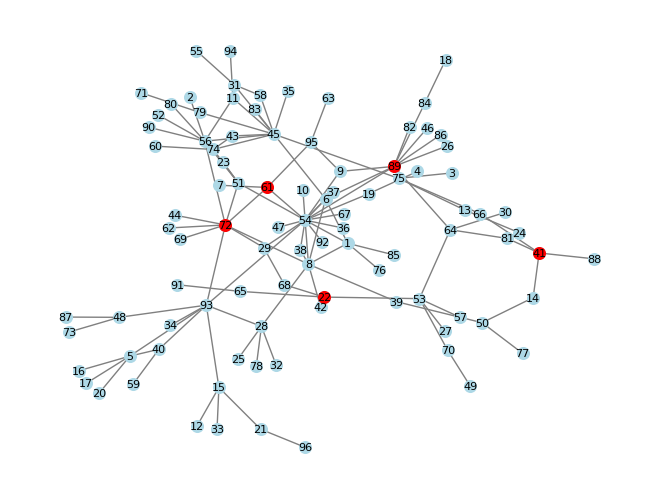

In [9]:
k=10
S_f1 = cost_seeds_greedy(G, k, costs, f1)
print("Seed set per f1:", S_f1)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f1, node_color='red', node_size=70)



Seed set per f1: {1, 66, 39, 72, 41, 9, 8, 81, 22, 54, 89, 61}


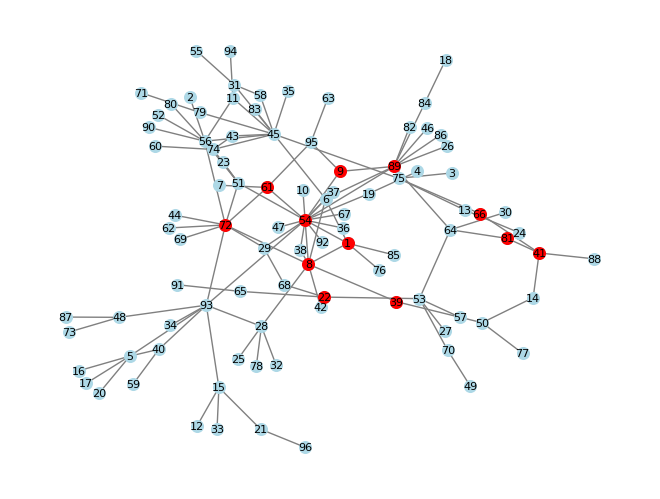

In [10]:
k=30
S_f1 = cost_seeds_greedy(G, k, costs, f1)
print("Seed set per f1:", S_f1)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f1, node_color='red', node_size=70)

Seed set per f1: {1, 66, 5, 72, 9, 8, 11, 73, 15, 81, 22, 89, 39, 41, 45, 54, 61}


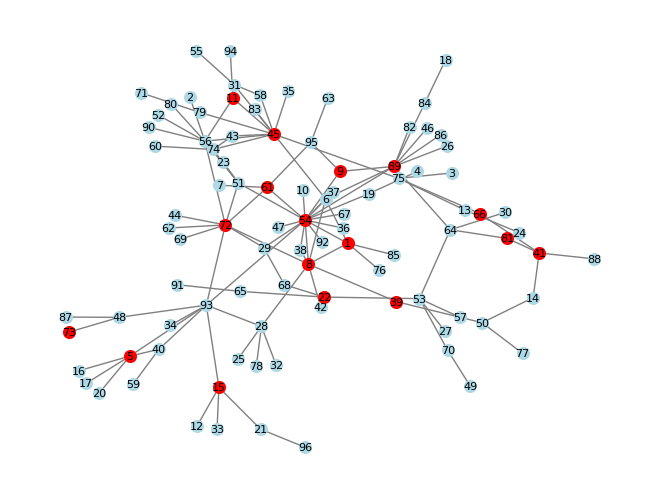

In [11]:
k=50
S_f1 = cost_seeds_greedy(G, k, costs, f1)
print("Seed set per f1:", S_f1)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f1, node_color='red', node_size=70)

Seed set per f2: {89, 1, 72, 9, 61}


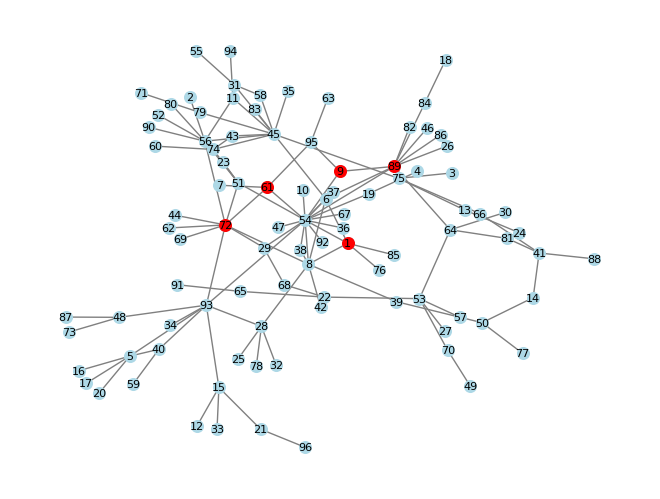

In [12]:
k=10
S_f2 = cost_seeds_greedy(G, k, costs, f2)
print("Seed set per f2:", S_f2)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f2, node_color='red', node_size=70)

Seed set per f2: {1, 66, 39, 72, 9, 41, 11, 8, 82, 22, 54, 89, 61}


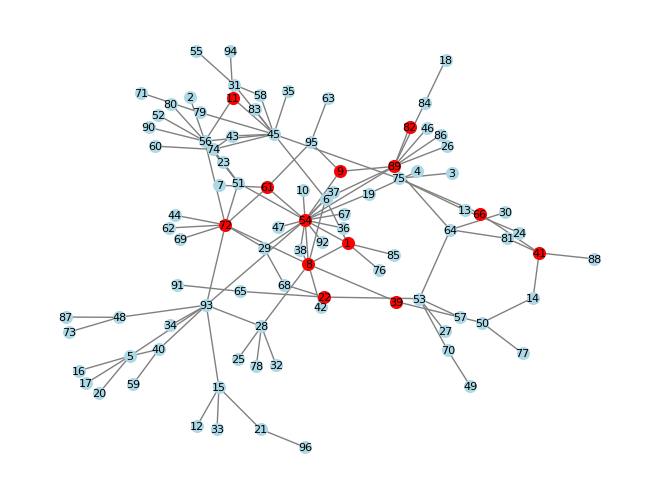

In [13]:
k=30
S_f2 = cost_seeds_greedy(G, k, costs, f2)
print("Seed set per f2:", S_f2)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f2, node_color='red', node_size=70)

Seed set per f2: {1, 66, 67, 8, 9, 72, 11, 73, 75, 81, 82, 84, 22, 89, 90, 93, 39, 41, 54, 61}


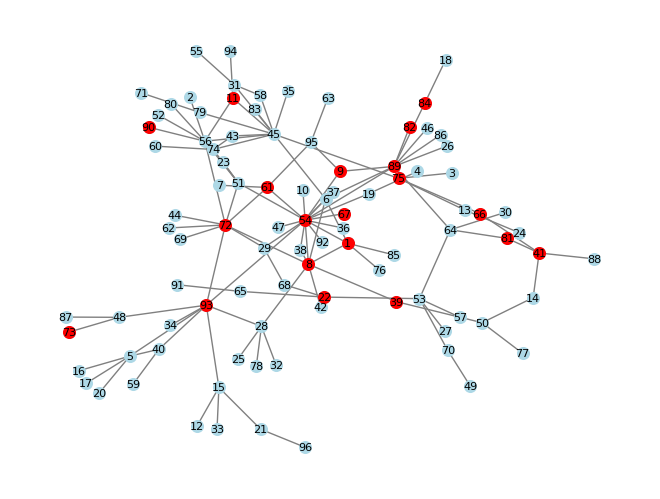

In [14]:
k=50
S_f2 = cost_seeds_greedy(G, k, costs, f2)
print("Seed set per f2:", S_f2)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f2, node_color='red', node_size=70)

Seed set per f3: {89, 1, 72, 9, 61}


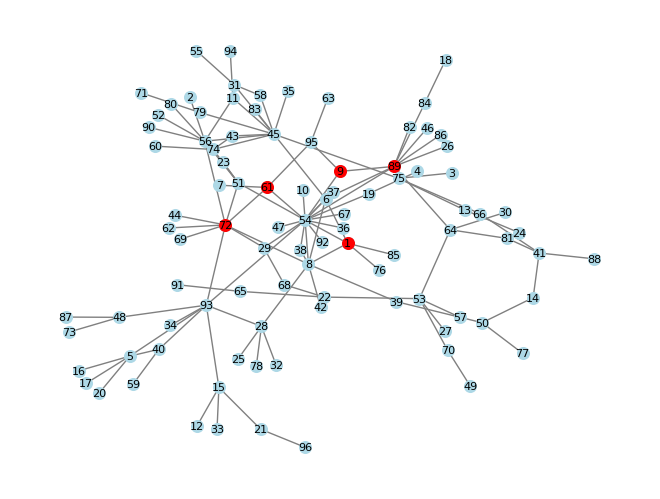

In [15]:
k=10
S_f3 = cost_seeds_greedy(G, k, costs, f3)
print("Seed set per f3:", S_f3)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f3, node_color='red', node_size=70)

Seed set per f3: {1, 66, 72, 9, 41, 11, 8, 82, 22, 54, 89, 61}


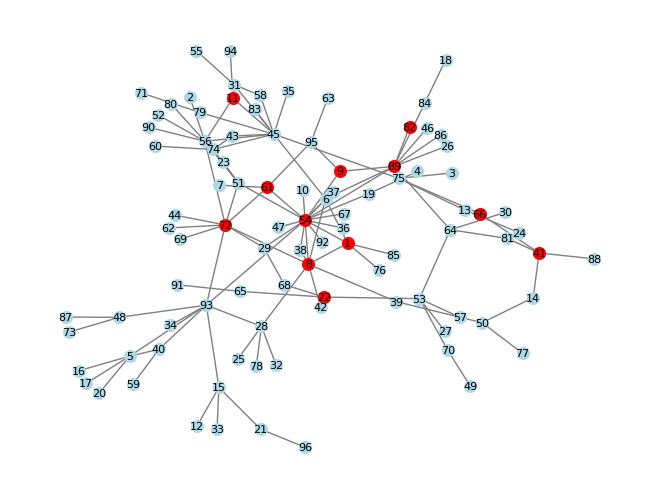

In [16]:
k=30
S_f3 = cost_seeds_greedy(G, k, costs, f3)
print("Seed set per f3:", S_f3)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f3, node_color='red', node_size=70)

Seed set per f3: {1, 66, 67, 5, 8, 9, 72, 11, 73, 75, 82, 22, 89, 90, 39, 41, 54, 56, 61}


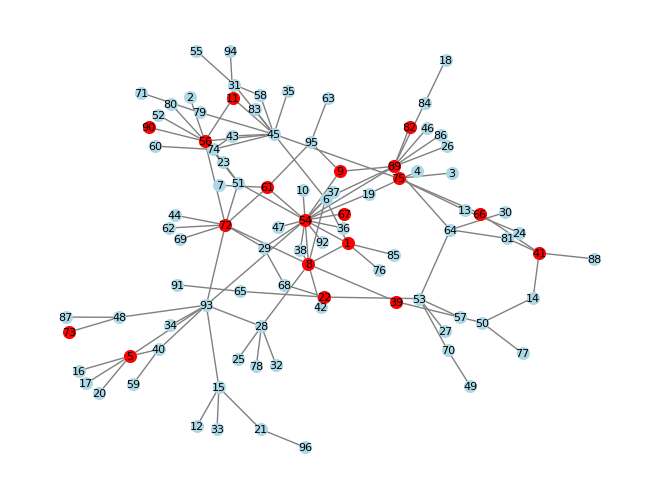

In [17]:
k=50
S_f3 = cost_seeds_greedy(G, k, costs, f3)
print("Seed set per f3:", S_f3)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=S_f3, node_color='red', node_size=70)

In [18]:
thresholds = {v: G.degree[v] / 2 for v in G.nodes()}

Seed set per algoritmo 2 : {88, 26, 7}


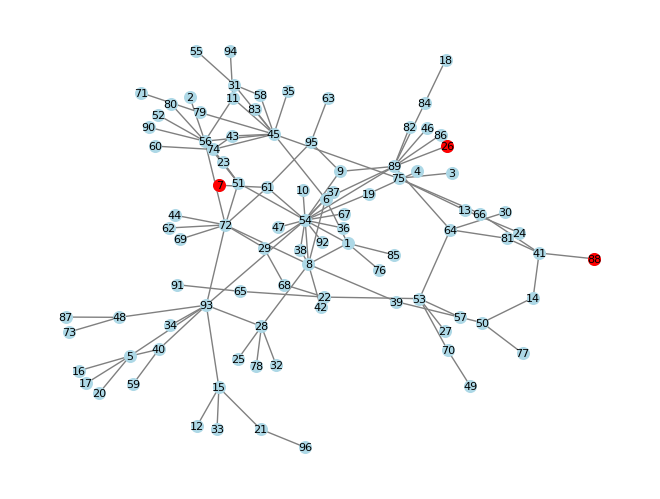

In [19]:
k=10
algoritmo_2=wtss(G,thresholds,costs,k)
print("Seed set per algoritmo 2 :", algoritmo_2)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=algoritmo_2, node_color='red', node_size=70)

Seed set per algoritmo 2 : {7, 76, 46, 82, 86, 88, 26}


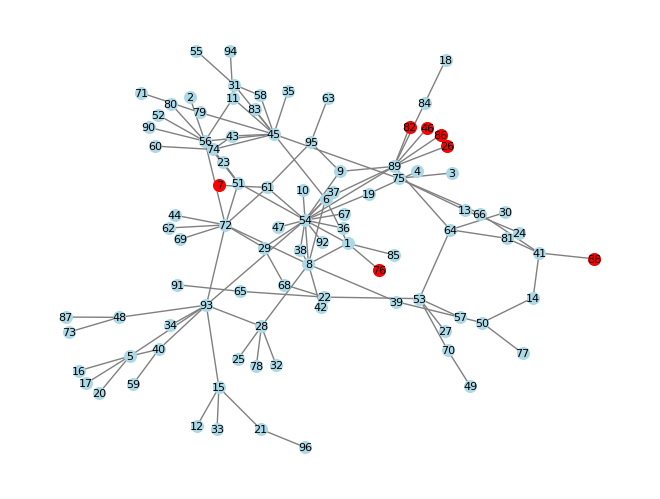

In [20]:
k=30
algoritmo_2=wtss(G,thresholds,costs,k)
print("Seed set per algoritmo 2 :", algoritmo_2)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=algoritmo_2, node_color='red', node_size=70)

Seed set per algoritmo 2 : {69, 7, 76, 44, 46, 82, 85, 86, 88, 26, 62}


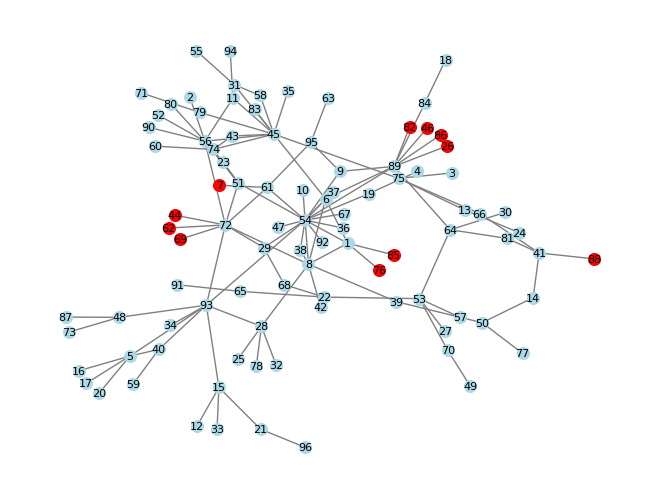

In [21]:
k=50
algoritmo_2=wtss(G,thresholds,costs,k)
print("Seed set per algoritmo 2 :", algoritmo_2)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=algoritmo_2, node_color='red', node_size=70)

Seed set per my_seeds: {66, 39, 41, 73, 42, 22, 89, 90, 61}


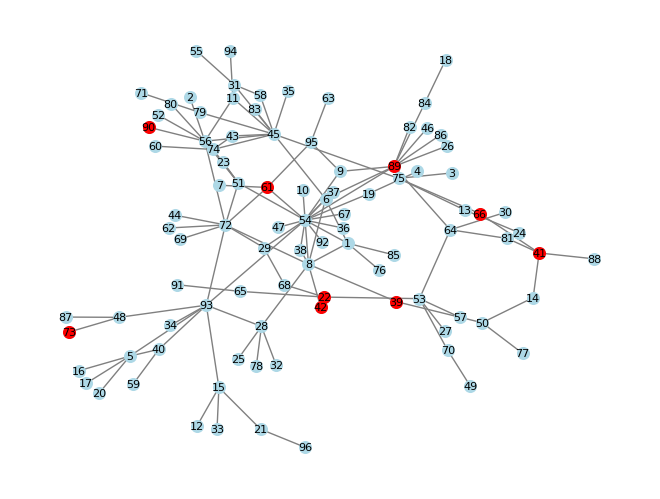

In [22]:
k=10
my_seeds_algorithm = my_seeds(G, k, costs)
print("Seed set per my_seeds:", my_seeds_algorithm)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=my_seeds_algorithm, node_color='red', node_size=70)

Seed set per my_seeds: {1, 2, 9, 22, 39, 41, 42, 61, 66, 67, 71, 73, 76, 78, 81, 82, 84, 88, 89, 90}


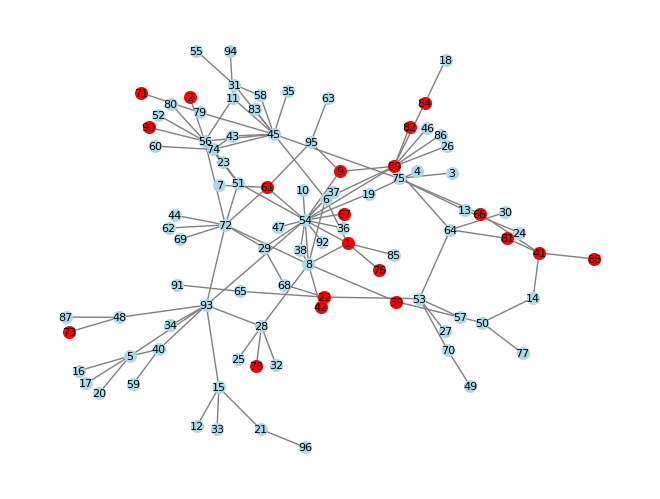

In [23]:
k=30
my_seeds_algorithm = my_seeds(G, k, costs)
print("Seed set per my_seeds:", my_seeds_algorithm)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=my_seeds_algorithm, node_color='red', node_size=70)

Seed set per my_seeds: {1, 2, 9, 11, 21, 22, 24, 26, 39, 41, 42, 61, 66, 67, 71, 72, 73, 75, 76, 78, 81, 82, 84, 88, 89, 90, 96}


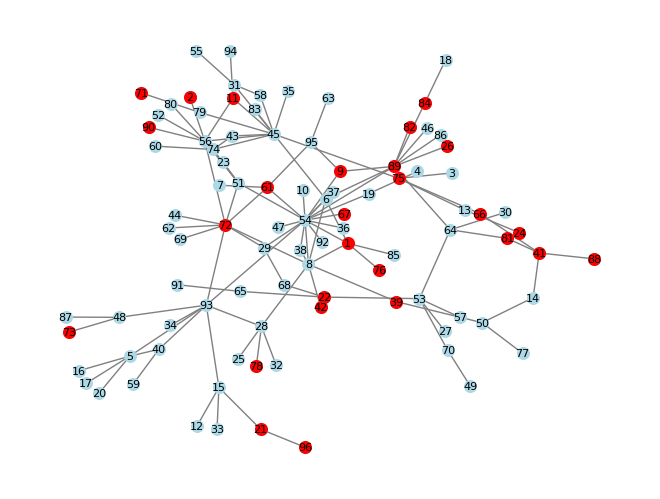

In [24]:
k=50
my_seeds_algorithm = my_seeds(G, k, costs)
print("Seed set per my_seeds:", my_seeds_algorithm)
# Draw the nodes and edges of the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=70, font_size=8, edge_color='gray')

# Highlight the nodes in the dominating set
nx.draw_networkx_nodes(G, pos, nodelist=my_seeds_algorithm, node_color='red', node_size=70)